# Analyzing and Predicting Accident Severity with UK Road Safety Data

- **Primary Objective**: Predict quantify accident severity levels (Slight, Serious, Fatal) using classification models.
- **Secondary Objective**: Analyze factors influencing accident severity using UK Road Safety data from 2023.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set_style("whitegrid")

### 1. Data Acquisition

In [14]:
df_collision = pd.read_csv('data//dft-road-casualty-statistics-collision-2023.csv', delimiter=',', low_memory=False)
df_vehicle = pd.read_csv('data//dft-road-casualty-statistics-vehicle-2023.csv', delimiter=',', low_memory=False)
df_casualty = pd.read_csv('data//dft-road-casualty-statistics-casualty-2023.csv', delimiter=',', low_memory=False)

print("Columns in df_collision:")
for col in df_collision.columns:
    print(f"  - {col}") 

print("\nColumns in df_vehicle:")
for col in df_vehicle.columns:
    print(f"  - {col}")

print("\nColumns in df_casualty:")
for col in df_casualty.columns:
    print(f"  - {col}")

df_merged = df_collision.merge(df_vehicle, on='accident_index', how='left')
df_merged = df_merged.merge(df_casualty, on='accident_index', how='left')

Columns in df_collision:
  - accident_index
  - accident_year
  - accident_reference
  - location_easting_osgr
  - location_northing_osgr
  - longitude
  - latitude
  - police_force
  - accident_severity
  - number_of_vehicles
  - number_of_casualties
  - date
  - day_of_week
  - time
  - local_authority_district
  - local_authority_ons_district
  - local_authority_highway
  - first_road_class
  - first_road_number
  - road_type
  - speed_limit
  - junction_detail
  - junction_control
  - second_road_class
  - second_road_number
  - pedestrian_crossing_human_control
  - pedestrian_crossing_physical_facilities
  - light_conditions
  - weather_conditions
  - road_surface_conditions
  - special_conditions_at_site
  - carriageway_hazards
  - urban_or_rural_area
  - did_police_officer_attend_scene_of_accident
  - trunk_road_flag
  - lsoa_of_accident_location
  - enhanced_severity_collision

Columns in df_vehicle:
  - accident_index
  - accident_year
  - accident_reference
  - vehicle_refere

### 2. Explanatory Data Analysis (EDA)

#### 2.1 Selecting Columns to Focus on

In [18]:
selected_columns = [
    'accident_severity', 
    'day_of_week', 
    'time',
    'road_surface_conditions', 
    'light_conditions', 
    'weather_conditions', 
    'road_type', 
    'junction_detail',
    'vehicle_type', 
    'age_of_driver',  
    'casualty_type',      
]
df_selected = df_merged[selected_columns]

#### 2.2 Handling Missing Data

In [20]:
df_selected = df_merged[selected_columns].replace(-1, pd.NA) 
miss_percentage = df_selected.isnull().sum() * 100 / len(df_selected)
print(miss_percentage)

accident_severity           0.000000
day_of_week                 0.000000
time                        0.000000
road_surface_conditions     0.871890
light_conditions            0.000000
weather_conditions          0.000000
road_type                   0.000000
junction_detail             0.000791
vehicle_type                0.155398
age_of_driver              13.860869
casualty_type               0.022539
dtype: float64


Mode imputing is used for low percentages of missing data, while the row with missing data is deleted for moderate rates.

In [22]:
df_clean = df_selected.copy()

for col in ['road_surface_conditions', 'junction_detail', 'vehicle_type', 'casualty_type']:
    mode_value = df_clean[col].mode()[0]
    df_clean[col].fillna(mode_value, inplace=True)
    
df_clean = df_clean.dropna(subset=['age_of_driver'])

# time column is formatted for ease of use
def time_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes
    
df_clean['time'] = df_clean['time'].apply(time_to_minutes)
df_selected = df_clean.copy()

C:\Users\elife\AppData\Local\Temp\ipykernel_35072\3402664734.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(mode_value, inplace=True)
C:\Users\elife\AppData\Local\Temp\ipykernel_35072\3402664734.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col].fillna(mode_value, inplac

#### 2.3 Visualizing Distributions and Correlations

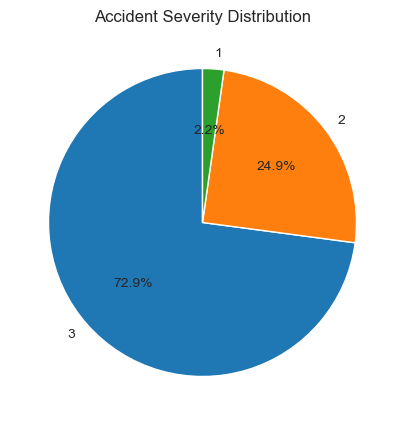

In [24]:
severity_counts = df_selected['accident_severity'].value_counts()
plt.figure(figsize=(8, 5))
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Accident Severity Distribution")
plt.show()

In [25]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    try:
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min(r - 1, k - 1))
    except ValueError:
        return np.nan

correlation_results = {}
for column in df_selected.columns:
    if column != 'accident_severity':
        confusion_matrix = pd.crosstab(df_selected[column], df_selected['accident_severity'])
        print(f"Processing {column}, Confusion Matrix:\n{confusion_matrix}")
        correlation_results[column] = cramers_v(confusion_matrix)

correlation_results = {k: v for k, v in correlation_results.items() if not pd.isna(v) and not isinstance(v, pd.Series)}
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Feature', 'CramersV'])

correlation_df = correlation_df.sort_values(by='CramersV', ascending=False)
print(correlation_df)

Processing day_of_week, Confusion Matrix:
accident_severity    1     2      3
day_of_week                        
1                  768  7278  17736
2                  743  6834  22161
3                  521  7479  23241
4                  484  7695  23480
5                  656  7742  24020
6                  881  8925  26477
7                  813  8224  21687
Processing time, Confusion Matrix:
accident_severity   1   2    3
time                          
0                   4   3   35
1                  15  32  167
2                  11  22   37
3                   3  12   25
4                   0   7   17
...                ..  ..  ...
1435                6  27   88
1436                4  12   25
1437                0  10   21
1438                2  23   14
1439                0   3   14

[1440 rows x 3 columns]
Processing road_surface_conditions, Confusion Matrix:
accident_severity           1      2       3
road_surface_conditions                     
1                        32

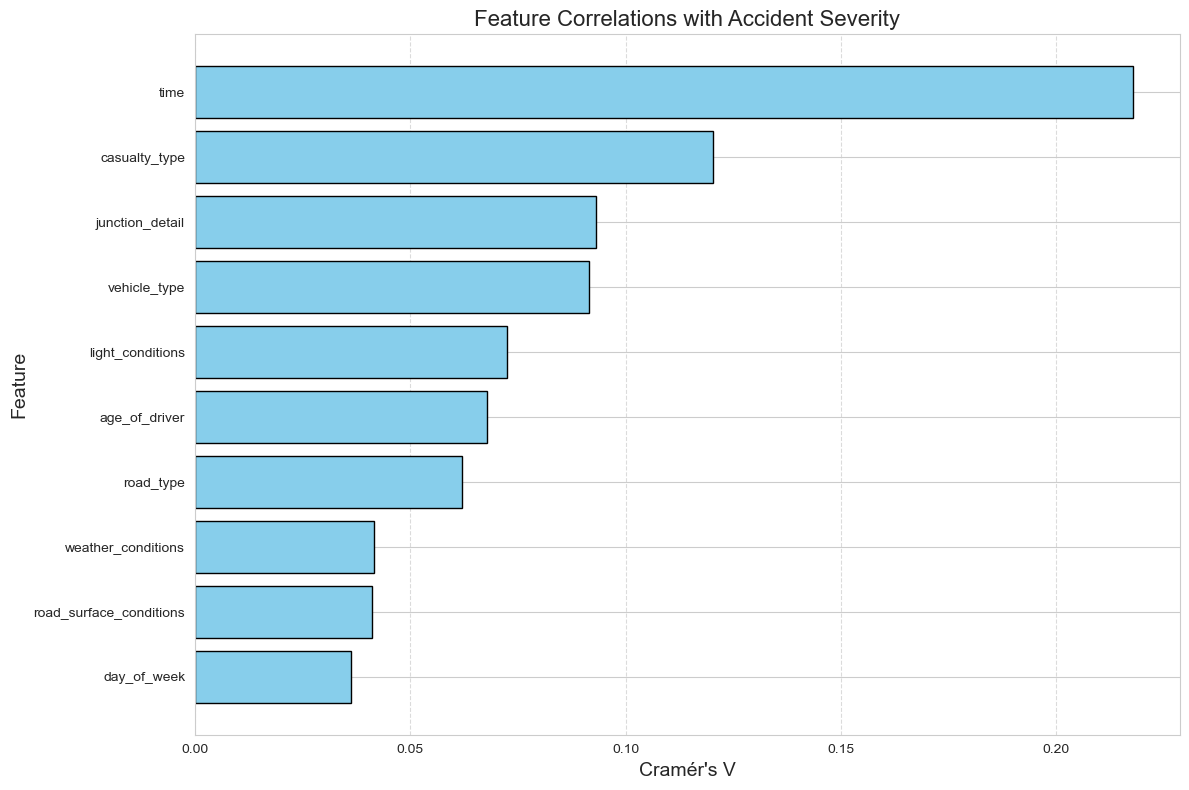

In [26]:
plt.figure(figsize=(12, 8))
plt.barh(correlation_df['Feature'], correlation_df['CramersV'], color='skyblue', edgecolor='black')
plt.xlabel('Cramér\'s V', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Correlations with Accident Severity', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3. Data Preprocessing

#### 3.1 Creating Target Variables

In [31]:
target_classification = 'accident_severity'
X = df_selected.drop(columns=[target_classification])  # Features
y_classification = df_selected[target_classification]  # Target


#### 3.2 Splitting the Training and Test Data for Logistic Regression

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_classification,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_classification)


### 4. Model Development

#### 4.1 Logistic Regression

In [40]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

logistic_model = LogisticRegression(C=0.01, #best parameters, found by hyperparameter tuning with GridSearchCV
        penalty='l1',  
        solver='liblinear',
        max_iter=1000,
        random_state=42)

logistic_model.fit(X_train_resampled, y_train_resampled)

y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(report)


Accuracy: 43.59%

Classification Report:
              precision    recall  f1-score   support

           1       0.04      0.59      0.07       973
           2       0.27      0.17      0.21     10835
           3       0.77      0.52      0.62     31761

    accuracy                           0.44     43569
   macro avg       0.36      0.43      0.30     43569
weighted avg       0.63      0.44      0.51     43569



#### 4.2 Random Forest Classifier

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracies = []
all_classification_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y_classification), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_classification.iloc[train_idx], y_classification.iloc[test_idx]
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
  
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    all_classification_reports.append(classification_rep)
    
    print(f"Fold {fold}: Accuracy = {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

mean_accuracy = np.mean(accuracies)
print(f"\nMean Accuracy Across {k} Folds: {mean_accuracy:.2f}")

#### 4.3 Decision Tree Classifier

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y_classification), 1):
    print(f"Fold {fold}")
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_classification.iloc[train_idx], y_classification.iloc[test_idx]
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_params = grid_search.best_params_
    print(f"Best Parameters for Fold {fold}: {best_params}")
    
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_resampled, y_train_resampled)
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold {fold} Accuracy: {accuracy:.2f}")
    print("-" * 50)

mean_accuracy = np.mean(accuracies)
print(f"\nMean Accuracy Across {kf.n_splits} Folds: {mean_accuracy:.2f}")

Fold 1
Best Parameters for Fold 1: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fold 1 Accuracy: 0.77
--------------------------------------------------
Fold 2
Best Parameters for Fold 2: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fold 2 Accuracy: 0.76
--------------------------------------------------
Fold 3
Best Parameters for Fold 3: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fold 3 Accuracy: 0.76
--------------------------------------------------
Fold 4
Best Parameters for Fold 4: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fold 4 Accuracy: 0.77
--------------------------------------------------
Fold 5
Best Parameters for Fold 5: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fold 5 Accuracy: 0.76
--------------------------------------------------

Mean Ac